## ch20 Better Models with ICE, Partial Dependence, Monotonic Constraints, and Calibration
- https://github.com/mattharrison/effective_xgboost_book/blob/main/xgbcode.ipynb

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.8.14</div>
<div style="text-align: right"> Last update: 2023.8.14</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

새롭게 라이브러리를 로드 하자.

In [2]:
import dtreeviz
from feature_engine import encoding, imputation
import numpy as np
import pandas as pd
from sklearn import base, compose, datasets, ensemble, \
    metrics, model_selection, pipeline, preprocessing, tree
import scikitplot
import xgboost as xgb
import yellowbrick.model_selection as ms
from yellowbrick import classifier

import urllib
import zipfile

import xg_helpers as xhelp
from xg_helpers import my_dot_export

In [3]:
url = 'https://github.com/mattharrison/datasets/raw/master/data/'\
'kaggle-survey-2018.zip'
fname = 'kaggle-survey-2018.zip'
member_name = 'multipleChoiceResponses.csv'

In [4]:
raw = xhelp.extract_zip(url, fname, member_name)
## Create raw X and raw y
kag_X, kag_y = xhelp.get_rawX_y(raw, 'Q6')

In [5]:
## Split data
kag_X_train, kag_X_test, kag_y_train, kag_y_test = \
model_selection.train_test_split(
kag_X, kag_y, test_size=.3, random_state=42, stratify=kag_y)

In [6]:
## Transform X with pipeline
X_train = xhelp.kag_pl.fit_transform(kag_X_train)
X_test = xhelp.kag_pl.transform(kag_X_test)
## Transform y with label encoder
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(kag_y_train)
y_train = label_encoder.transform(kag_y_train)
y_test = label_encoder.transform(kag_y_test)
# Combined Data for cross validation/etc
X = pd.concat([X_train, X_test], axis='index')
y = pd.Series([*y_train, *y_test], index=X.index)

In [7]:
X.head()

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat
587,25,18.0,4.0,0,1,0,1,1,0,0,0,0,1,0,0,1,0,0
3065,22,16.0,1.0,10000,1,0,0,1,0,0,0,0,1,0,1,0,0,0
8435,22,18.0,1.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3110,40,20.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0
16372,45,12.0,5.0,100000,1,0,1,1,0,0,0,1,0,0,0,1,0,0


In [8]:
y.head()

587      1
3065     0
8435     0
3110     0
16372    1
dtype: int64

이 장에서는 XGBoost 모델의 해석 가능성과 성능을 개선하는 데 사용할 수 있는 몇 가지 고급 기법을 살펴보겠습니다. 

여기서는 개별 조건부 Individual ConditionalExpectation(ICE), Partial Dependence Plots 플롯(PDP)에 대해 설명합니다. 
이러한 강력한 시각화 도구를 사용하면 입력 기능이 모델의 예측에 어떤 영향을 미치는지 이해할 수 있습니다.

또한 과적합을 방지하고 일반화 성능을 개선하기 위해 XGBoost 모델을 제약하는 방법도 살펴봅니다.  
이 장에서는 XGBoost 모델에서 가치 있는 인사이트를 추출하는 데 사용할 수 있는 몇 가지 중요한 기법에 대한 포괄적인 개요를 제공합니다.

### 20.1 ICE Plots

Individual Conditional Expectation (ICE) plot은 하나의 입력 변수가 머신 러닝 모델의 출력에 미치는 영향을 시각화하는 데 유용한 도구입니다.  
XGBoost의 맥락에서 ICE 플롯은 각 피처가 모델의 최종 예측에 어떻게 기여하는지 이해하는 데 도움이 될 수 있습니다.  

이 섹션에서는 Python을 사용하여 XGBoost 모델에 대한 ICE 플롯을 만드는 방법을 살펴봅니다.  
ICE 플롯은 특정 입력 특징의 값이 변할 때 단일 관측값에 대한 머신 러닝 모델의 예측 값을 보여줍니다.  

즉, ICE 플롯은 한 입력 특징의 값을 점진적으로 변경하면서 고정 인스턴스에 대한 모델의 출력을 표시합니다.  
플롯의 각 선은 입력 특징이 변경될 때 특정 인스턴스에 대한 예측된 출력을 나타냅니다.  
각 선의 모양과 기울기를 살펴보면 모델이 해당 입력 특징을 사용하여 예측을 수행하는 방식에 대한 인사이트를 얻을 수 있습니다.  
ICE 플롯은 단일 입력 특징과 모델의 예측 간의 관계를 자세히 보여 줍니다. 

단일 샘플에 대한 ICE 플롯을 만들려면 다음 단계를 따르세요:

1. 분석할 입력 피처를 선택하고 해당 피처의 변경할 값 범위를 선택합니다.  

2. 다른 모든 입력 피처의 값을 관심 인스턴스에 대해 관찰된 값으로 고정합니다.  

3. 1단계에서 선택한 값에 대해 선택한 입력 특징을 변경합니다.  

4. 선택한 입력 피처의 각 값에 대해 관심 있는 특정 인스턴스에 대한 모델의 해당 예측을 계산합니다.  

5. 4단계에서 얻은 값을 입력 특징의 해당 값에 대해 플롯하여 ICE 플롯에 한 줄을 만듭니다.  

In [9]:
xgb_def = xgb.XGBClassifier(random_state=42)
xgb_def.fit(X_train, y_train)
xgb_def.score(X_test, y_test)

0.7458563535911602

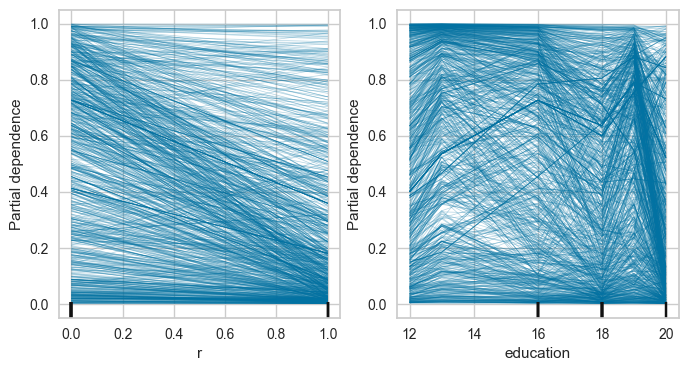

In [10]:
from sklearn.inspection import PartialDependenceDisplay
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
kind='individual', ax=axes)

- R 값이 양수일수록 데이터 과학자의 확률이 높아지는 경향이 있습니다.  
- 교육의 경우에도 교육 수준이 높을수록 데이터 과학자를 선호하는 경향이 있는 것으로 나타났습니다.

???

위 차트로는 무슨 일이 일어나고 있는지 파악하기는 조금 어렵습니다. 

- 이 플롯의 Y축은 최종 레이블인 소프트웨어 엔지니어(1) 또는 데이터 과학자(0)의 확률을 나타냅니다.

- r이 1이 되면 데이터 과학자 쪽이 강하게 밀리는 것입니다.  
- education 플롯의 경우, education 값이 낮을수록 소프트웨어 엔지니어로, 값이 클수록 데이터 과학자로 밀리는 경향이 있습니다.

- 비주얼리제이션을 더 명확하게 만드는 데 도움이 되는 한 가지 기법은 비주얼리제이션이 모두 왼쪽의 동일한 값에서 시작하도록 하는 것입니다. 중앙에 매개 변수를 사용하면 됩니다.

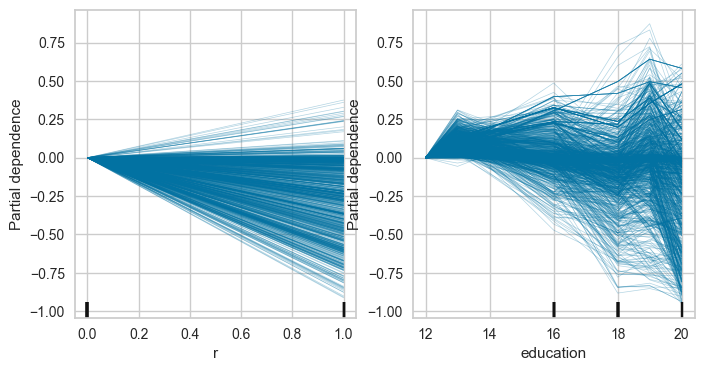

In [11]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
centered=True,
kind='individual', ax=axes)

또한 이 플롯에서 하단의 눈금은 해당 값을 가진 rows의 수를 시각화하기 위한 것입니다.  
그러나 설문조사 데이터의 구간차원 값으로 인해 education 수준을 식별할 수 없습니다. 

상단에 히스토그램을 표시하여 분포를 확인할 수 있습니다. 이를 통해 데이터의 밀도를 직관적으로 파악할 수 있습니다.

데이터가 많은 지역일수록 더 나은 예측을 하는 경향이 있습니다.   
education의 경우, 교육 기간이 14년 미만인 응답자의 예가 많지 않습니다.  
따라서 예측에 대한 불확실성이 더 커질 수 있습니다.

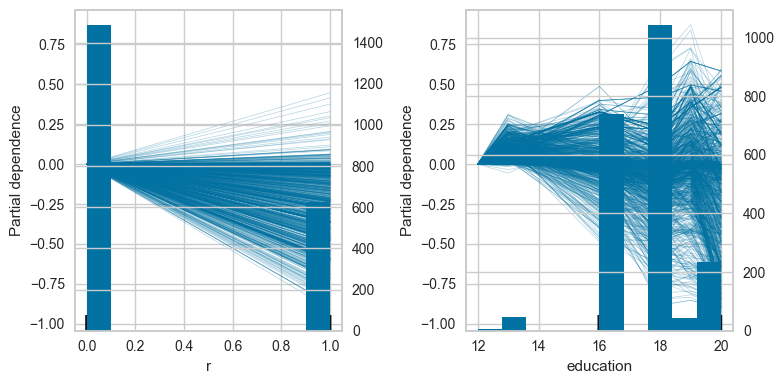

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
ax_h0 = axes[0].twinx()
ax_h0.hist(X_train.r, zorder=0)
ax_h1 = axes[1].twinx()
ax_h1.hist(X_train.education, zorder=0)
PartialDependenceDisplay.from_estimator(xgb_def, X_train, features=['r', 'education'],
centered=True,
ice_lines_kw={'zorder':10},
kind='individual', ax=axes)
fig.tight_layout()

저는 예측 확률의 사분위수로 피처를 세분화하고 각 사분위수의 평균으로 선을 만드는 함수인 quantile_ice를 작성했습니다. 이 함수는 또한 히스토그램을 표시할 수도 있습니다.

In [13]:
def quantile_ice(clf, X, col, center=True, q=10, color='k', alpha=.5, legend=True,
                add_hist=False, title='', val_limit=10, ax=None):
  """
    Generate an ICE plot for a binary classifier's predicted probabilities split 
    by quantiles.

    Parameters:
    ----------
    clf : binary classifier
        A binary classifier with a `predict_proba` method.
    X : DataFrame
        Feature matrix to predict on with shape (n_samples, n_features).
    col : str
        Name of column in `X` to plot against the quantiles of predicted probabilities.
    center : bool, default=True
        Whether to center the plot on 0.5.
    q : int, default=10
        Number of quantiles to split the predicted probabilities into.
    color : str or array-like, default='k'
        Color(s) of the lines in the plot.
    alpha : float, default=0.5
        Opacity of the lines in the plot.
    legend : bool, default=True
        Whether to show the plot legend.
    add_hist : bool, default=False
        Whether to add a histogram of the `col` variable to the plot.
    title : str, default=''
        Title of the plot.
    val_limit : num, default=10
        Maximum number of values to test for col.
    ax : Matplotlib Axis, deafault=None
        Axis to plot on.

    Returns:
    -------
    results : DataFrame
        A DataFrame with the same columns as `X`, as well as a `prob` column with 
        the predicted probabilities of `clf` for each row in `X`, and a `group` 
        column indicating which quantile group the row belongs to.
  """                  
  probs = clf.predict_proba(X)
  df = (X
        .assign(probs=probs[:,-1],
               p_bin=lambda df_:pd.qcut(df_.probs, q=q, 
                                        labels=[f'q{n}' for n in range(1,q+1)])
               )
       )
  groups = df.groupby('p_bin')

  vals = X.loc[:,col].unique()
  if len(vals) > val_limit:
    vals = np.linspace(min(vals), max(vals), num=val_limit)
  res = []
  for name,g in groups:
    for val in vals:
      this_X = g.loc[:,X.columns].assign(**{col:val})
      q_prob = clf.predict_proba(this_X)[:,-1]
      res.append(this_X.assign(prob=q_prob, group=name))
  results = pd.concat(res, axis='index')     
  if ax is None:
    fig, ax = plt.subplots(figsize=(8,4))
  if add_hist:
    back_ax = ax.twinx()
    back_ax.hist(X[col], density=True, alpha=.2) 
  for name, g in results.groupby('group'):
    g.groupby(col).prob.mean().plot(ax=ax, label=name, color=color, alpha=alpha)
  if legend:
    ax.legend()
  if title:
    ax.set_title(title)
  return results

Let’s plot the 10 quantiles for the education feature. Ideally, these lines do not cross each
other. If they do cross, you might want to debug the model to make sure that it isn’t overfitting
on sparse data.

,age,education,years_exp,compensation,python,r,sql,Q1_Male,Q1_Female,Q1_Prefer not to say,Q1_Prefer to self-describe,Q3_United States of America,Q3_India,Q3_China,major_cs,major_other,major_eng,major_stat,prob,group
3110,40,18.0,3.0,125000,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0.005568,q1
3798,35,18.0,4.0,125000,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0.020992,q1
18640,18,18.0,2.0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,1,0.001421,q1
2621,25,18.0,1.0,125000,1,1,1,1,0,0,0,1,0,0,0,0,0,1,0.007570,q1
4035,30,18.0,2.0,125000,1,1,1,0,1,0,0,1,0,0,0,1,0,0,0.001280,q1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21587,35,19.0,10.0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0.918584,q10
21649,35,19.0,15.0,10000,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0.933382,q10
4196,60,19.0,20.0,100000,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0.983405,q10
16608,25,19.0,2.0,10000,0,0,1,1,0,0,0,0,1,0,1,0,0,0,0.914242,q10


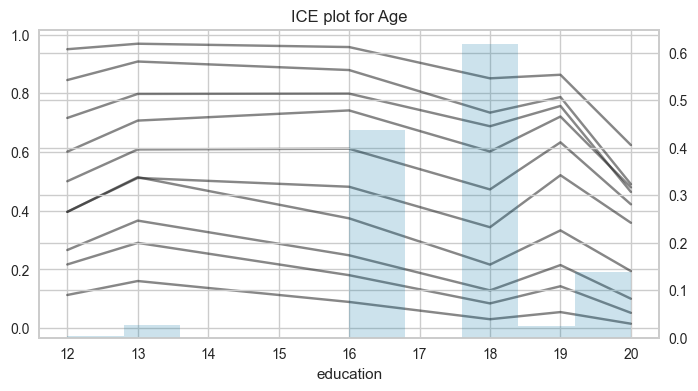

In [14]:
fig, ax = plt.subplots(figsize=(8,4))
quantile_ice(xgb_def, X_train, 'education', q=10, legend=False, add_hist=True, ax=ax,
            title='ICE plot for Age')